In [1]:
import rospy
import inspect
import numpy as np
import time
from robotblockset.graphics import plotjtraj
import matplotlib.pyplot as plt
from utils import SoftSetJointCompliance
from dmp import DMP
from tp import*



from robotblockset.ros.grippers_ros import PandaGripper
from importlib import reload
import example_data_recorder
#reload(example_data_recorder)
from utils import SoftSetJointCompliance
ns = "pingvin_2"
rospy.init_node(ns)
from robotblockset.ros.franka import panda_ros
r = panda_ros(ns=ns, control_strategy="JointImpedance", init_node=False)
g = PandaGripper(namespace=ns,robot=r)
import csv

Make sure that ROS node is initialized outside
Panda::Initialized
Panda:Gripper:ROS:Created


In [3]:
def record_robot_state(robot, frequency, duration):
    interval = 1.0 / frequency
    
    N=int(frequency*duration)
    tt = np.zeros((N,1))
    qt = np.zeros((N,r.nj))
    dqt = np.zeros((N,r.nj))
    xt = np.zeros((N,r.nj))

    i = 0
    start_time = time.monotonic()
    end_time = start_time + duration
    
    last_update = time.monotonic()

    while time.monotonic() <= end_time+interval and i < N:
        t = time.monotonic()
        if t - last_update >= interval:
            
            # Get robot state
            state = robot.GetState()
            xt[i] = robot.x
            tt[i] = t-start_time
            qt[i] = robot.q
            dqt[i] = robot.qdot

            # Update the last recorded time
            last_update = t
            i += 1
        
    return xt, tt, qt, dqt, i, N   

In [ ]:
r.ErrorRecovery()

In [36]:
r.SetJointCompliant()

:Joint compliance changed 
Stiff:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
Damp:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]


In [12]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)
r.SetJointStiff()

:Joint compliance changed 
Stiff:[1200. 1200. 1200. 1200.    0.    0.    0.]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[1200. 1200. 1200. 1200.  250.  250.  100.]
Damp:[25. 25. 25. 25. 10. 10. 10.]


In [37]:
r.SetJointCompliant()
print("START")
xt, tt, qt, dqt, i, N = record_robot_state(r,100,15)
print("STOP")

:Joint compliance changed 
Stiff:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
Damp:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
START
STOP


In [44]:
r.SetJointCompliant()
print("START")
xt_above, tt_above, qt_above, dqt_above, i_above, N_above = record_robot_state(r,100,3)
print("STOP")

:Joint compliance changed 
Stiff:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
Damp:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
START
STOP


In [81]:
print(qt.shape)
print(tt.shape)
print(dqt.shape)

(1000, 7)
(1000, 1)
(1000, 7)


In [71]:
qt=qt[0:-1,:]
tt=tt[0:-1,:]
dqt=dqt[0:-1,:]

In [62]:
print(qt[-13, :])

[ 0.0659  0.0402 -0.1430 -2.3814 -0.0009  2.2362  2.2214]


In [6]:
g.Close()

1

In [10]:
g.Open()

1

In [44]:
np.count_nonzero(np.isinf(np.squeeze(qt.copy())))

0

In [45]:
np.count_nonzero(np.isnan(np.squeeze(qt.copy())))

0

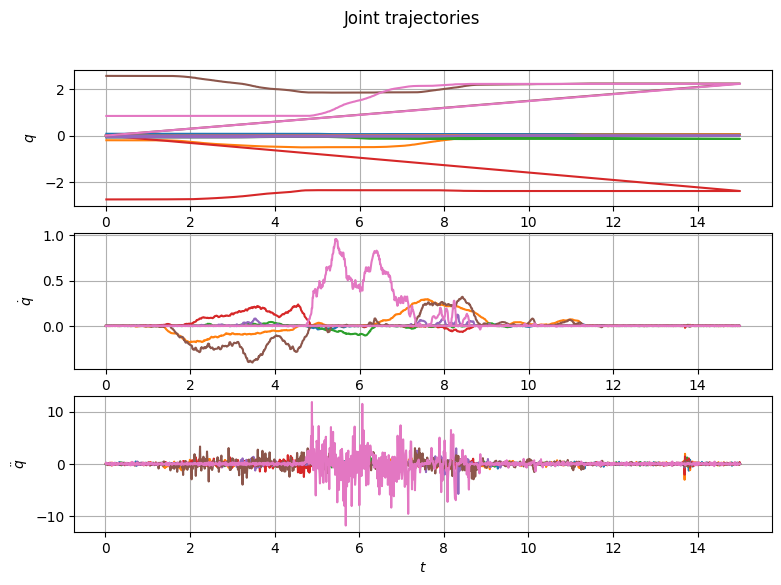

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle('Joint trajectories')
plotjtraj(tt.copy(), qt.copy(), dqt.copy(), ax=ax);

In [31]:
d = DMP(qt[:-13].copy(),np.squeeze(tt[:-13].copy()),dqt[:-13].copy(),num_weights=50)

In [32]:
trj_dec,t_dec=d.decode()

In [65]:
trj_dec.shape

(1486, 7)

In [19]:
np.savetxt("trj_dec2nd.csv", trj_dec, delimiter=",", fmt="%s")
np.savetxt("t_dec2nd.csv", t_dec, delimiter=",", fmt="%s")

In [22]:
trj_dec = np.genfromtxt('trj_dec.csv', delimiter=',')
t_dec = np.genfromtxt('t_dec.csv', delimiter=',')


In [67]:
trj_dec.shape

(1486, 7)

In [33]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)
r.SetJointStiff()

:Joint compliance changed 
Stiff:[ 1200.0000  1200.0000  1200.0000  1200.0000  0.0000  0.0000  0.0000]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[ 1200.0000  1200.0000  1200.0000  1200.0000  250.0000  250.0000  100.0000]
Damp:[ 25.0000  25.0000  25.0000  25.0000  10.0000  10.0000  10.0000]


In [4]:
r.SetJointCompliant()


:Joint compliance changed 
Stiff:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
Damp:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
ERROR! Session/line number was not unique in database. History logging moved to new session 143


In [34]:
r.JMove(trj_dec[0],3)
i = 0
trq = np.zeros_like(trj_dec)
for q in trj_dec: 
    r.GoTo_q(q,np.zeros(7),np.zeros(7),0)
    trq[i] = np.array(r.state.tau_J_d) #new line to store trqs
    i += 1
    time.sleep(1/100.)

In [2]:
r.ErrorRecovery()

Panda::Recovering from errors:
 ['cartesian_reflex']
Panda::Attempting to change robot mode from 4


0

In [20]:
np.savetxt("trq_recorded2nd.csv", trq, delimiter=",", fmt="%s")

In [25]:
trq_dec.shape

(1486, 7)

In [21]:
tp = TP(trq.copy(), np.squeeze(t_dec.copy()), num_weights=200)

In [22]:
trq_dec, trq_t = tp.decode()

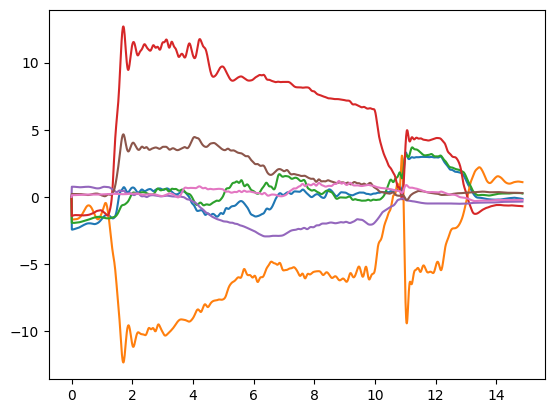

In [24]:
plt.plot(t_dec, trq_dec)
plt.show()

In [23]:
trq_dec = (np.vstack((np.zeros((1,7)),trq_dec)))

In [26]:
np.savetxt("trq_tp_weights2nd.csv", trq_dec, delimiter=",", fmt="%s")
np.savetxt("trq_t_tp_weights2nd.csv", trq_t, delimiter=",", fmt="%s")

In [68]:
np.savetxt("xt_above2.csv", xt_above[0], delimiter=",", fmt="%s")
np.savetxt("qt_above2.csv", qt_above[0], delimiter=",", fmt="%s")

In [5]:
xt_above = np.genfromtxt('xt_above2.csv', delimiter=',')
qt_above = np.genfromtxt('qt_above2.csvimport random

stiffness_values = [0.1, 0.2, 0.4, 0.5, 0.6]
#stiffness_values = [ 0.2, 0.4]

random.shuffle(stiffness_values)

for stiffness in stiffness_values:
    print(f"\n=== Executing CMP with stiffness = {stiffness} ===")

    r.ResetCurrentTarget()
    SoftSetJointCompliance(r, r._franka_default.JointCompliance.K, 4)
    r.SetJointStiff()
    r.CMove(xt_above, 3)
    r.JMove(trj_dec[0], 3)
    r.SetJointSoft(stiffness)

    qTestCMP2 = np.zeros_like(trj_dec)

    for i, q in enumerate(trj_dec): 
        r.GoTo_q(q, np.zeros(7), trq_dec[i], 0)
        qTestCMP2[i] = np.array(r.q)
        time.sleep(1/100.)
        
    input("⚠️  Please fill in the form and press ENTER to continue to the next stiffness...")', delimiter=',')

SyntaxError: EOL while scanning string literal (3262080450.py, line 2)

In [ ]:
r.CMove(xt_above,3)


In [5]:
r.ErrorRecovery()

Panda::Recovering from errors:
 ['cartesian_reflex']
Panda::Attempting to change robot mode from 4


0

In [4]:
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)
r.SetJointStiff()
r.CMove(xt_above,3)
r.JMove(trj_dec[0],3)
r.SetJointSoft(0.6)
i = 0
qTestCMP2 = np.zeros_like(trj_dec)
for q in trj_dec: 
    r.GoTo_q(q,np.zeros(7),trq_dec[i],0)
    qTestCMP2[i] = np.array(r.q) #new line to store qs
    i += 1
    time.sleep(1/100.)

:Joint compliance changed 
Stiff:[1200 1200 1200 1200  250  250  100]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[1200. 1200. 1200. 1200.  250.  250.  100.]
Damp:[25. 25. 25. 25. 10. 10. 10.]
:Joint compliance changed 
Stiff:[ 720.0000  720.0000  720.0000  720.0000  150.0000  150.0000  60.0000]
Damp:[ 15.0000  15.0000  15.0000  15.0000  6.0000  6.0000  6.0000]


In [7]:
pip install keyboard


     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [13]:
r.SetJointCompliant()

:Joint compliance changed 
Stiff:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
Damp:[ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]


In [12]:
pip()

TypeError: 'module' object is not callable

In [6]:
import random

#stiffness_values = [0.1, 0.2, 0.4, 0.5, 0.6]
stiffness_values = [ 0.4]

random.shuffle(stiffness_values)

for stiffness in stiffness_values:
    print(f"\n=== Executing CMP with stiffness = {stiffness} ===")

    r.ResetCurrentTarget()
    SoftSetJointCompliance(r, r._franka_default.JointCompliance.K, 4)
    r.SetJointStiff()
    r.CMove(xt_above, 3)
    r.JMove(trj_dec[0], 3)
    r.SetJointSoft(stiffness)

    qTestCMP2 = np.zeros_like(trj_dec)
    
    trq_rec2 = np.zeros_like(trj_dec)

    for i, q in enumerate(trj_dec): 
        r.GoTo_q(q, np.zeros(7), trq_dec[i], 0)
        qTestCMP2[i] = np.array(r.q)
        time.sleep(1/100.)
        trq_rec2[i] = np.array(r.state.tau_J_d) #new line to store trqs

        
    input("⚠️  Please fill in the form and press ENTER to continue to the next stiffness...")


=== Executing CMP with stiffness = 0.4 ===
:Joint compliance changed 
Stiff:[ 480.0000  480.0000  480.0000  480.0000  100.0000  100.0000  40.0000]
Damp:[25 25 25 25 10 10 10]
:Joint compliance changed 
Stiff:[ 1200.0000  1200.0000  1200.0000  1200.0000  250.0000  250.0000  100.0000]
Damp:[ 25.0000  25.0000  25.0000  25.0000  10.0000  10.0000  10.0000]
:Joint compliance changed 
Stiff:[ 480.0000  480.0000  480.0000  480.0000  100.0000  100.0000  40.0000]
Damp:[ 10.0000  10.0000  10.0000  10.0000  4.0000  4.0000  4.0000]


⚠️  Please fill in the form and press ENTER to continue to the next stiffness... 


In [3]:
trj_dec = np.genfromtxt('trj_dec2.csv', delimiter=',')
t_dec = np.genfromtxt('trq_t_tp_weights2.csv', delimiter=',')
xt_above = np.genfromtxt('xt_above2.csv', delimiter=',')
qt_above = np.genfromtxt('qt_above2.csv', delimiter=',')
trq_dec = np.genfromtxt('trq_tp_weights2.csv', delimiter=',')


In [11]:
t_dec.shape

(1485,)

In [10]:
t_dec = np.genfromtxt('trq_t_tp_weights2.csv', delimiter=',')

In [15]:
trj_dec.shape

(995, 7)

[[ 1.0000  0.0000  0.0000  0.0000]
 [ 0.0000  1.0000  0.0000  0.0000]
 [ 0.0000  0.0000  1.0000  0.0000]
 [ 0.0000  0.0000  0.0000  1.0000]]


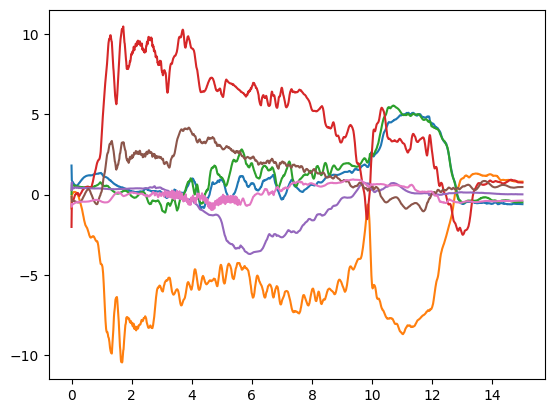

In [20]:
plt.plot(t_dec, trq_rec2)
plt.show()

In [12]:
print(t_dec[-1])

14.849457376015163


In [18]:
t_dec = np.append(t_dec, 15)

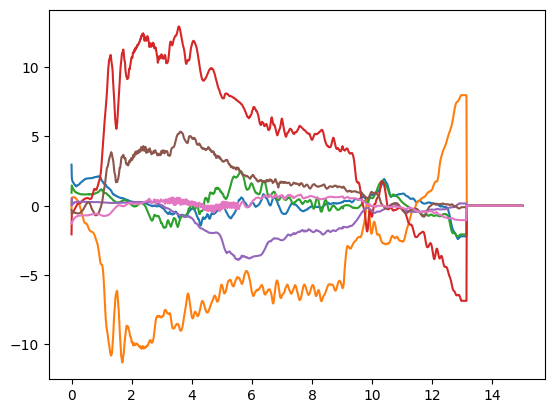

In [21]:
plt.plot(t_dec, trq_rec)
plt.show()